In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Subset
from tqdm import tqdm


## Model

class LatentDiffusionModel(nn.Module):
    def __init__(self, num_steps, beta_schedule, image_size, num_classes):
        super(LatentDiffusionModel, self).__init__()
        self.num_steps = num_steps
        self.beta_schedule = beta_schedule
        self.image_size = image_size
        self.num_classes = num_classes

        # UNet model for denoising
        self.unet = UNet(image_size, num_classes)

    def forward(self, x, labels):
        # Forward diffusion process
        x_noisy = self.diffuse(x)
        # Reverse diffusion process
        x_reconstructed = self.denoise(x_noisy, labels)
        return x_reconstructed

    def diffuse(self, x):
        # Forward diffusion process
        batch_size = x.shape[0]
        beta_index = torch.randint(0, len(self.beta_schedule), (1,), device=x.device)
        beta = torch.tensor(self.beta_schedule, device=x.device)[beta_index]
        eps = torch.randn_like(x)
        x_noisy = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps
        return x_noisy

    def denoise(self, x_noisy, labels):
        # Reverse diffusion process using UNet
        x_reconstructed = self.unet(x_noisy, labels)
        return x_reconstructed


class UNet(nn.Module):
    def __init__(self, image_size, num_classes):
        super(UNet, self).__init__()
        self.image_size = image_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3),
            nn.Upsample(size=(image_size, image_size), mode='nearest')
        )
        self.fc = nn.Linear(12800, num_classes)

    def forward(self, x, labels):
        x = self.encoder(x)
        x = self.decoder(x)
        # x = x.view(-1, 1, self.image_size, self.image_size)
        return x


## Training

def train(model, device, loader, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in tqdm(enumerate(loader)):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = nn.MSELoss()(model(data, labels), data)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    return total_loss

In [2]:
import os

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Hyperparameters
num_steps = 1000
# beta_schedule = np.linspace(0.0001, 0.02, num_steps)
beta_schedule = torch.linspace(0.0001, 0.02, num_steps, device=device)
image_size = 28
num_classes = 10
batch_size = 128
epochs = 10

save_dir = "checkpoints"

# Create directories
os.makedirs(save_dir, exist_ok=True)

# Model
model = LatentDiffusionModel(num_steps, beta_schedule, image_size, num_classes)
save_dir = "checkpoints"
checkpoint = torch.load(os.path.join(save_dir, "test_model.pth"))
model.load_state_dict(checkpoint['model'])
model.to(device)

# Data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# trainset = Subset(trainset, indices=range(1000))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train
for epoch in range(1, epochs + 1):
    loss = train(model, device, train_loader, optimizer)
    print(f'Epoch {epoch}: loss {loss}')

    if (epoch+1)%epochs == 0:
        # Save checkpoint
        torch.save({
            'model': model.state_dict()
        }, os.path.join(save_dir, f"test_model.pth"))

/var/folders/gc/kz__mt8x4_5dt3kw4bq0vxm80000gn/T/ipykernel_95069/4230208394.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_di

Epoch 1: loss 16.321698581799865


469it [00:20, 22.62it/s]


Epoch 2: loss 14.918924437835813


469it [00:20, 22.97it/s]


Epoch 3: loss 14.97326336428523


469it [00:20, 22.91it/s]


Epoch 4: loss 14.995620805770159


469it [00:20, 22.93it/s]


Epoch 5: loss 15.076764795929193


469it [00:20, 22.72it/s]


Epoch 6: loss 15.052134364843369


469it [00:20, 22.88it/s]


Epoch 7: loss 15.043930785730481


469it [00:20, 22.41it/s]


Epoch 8: loss 15.196451039984822


469it [00:20, 22.55it/s]


Epoch 9: loss 15.058574741706252


469it [00:20, 22.91it/s]

Epoch 10: loss 15.021409897133708


/var/folders/gc/kz__mt8x4_5dt3kw4bq0vxm80000gn/T/ipykernel_95069/627584839.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir,

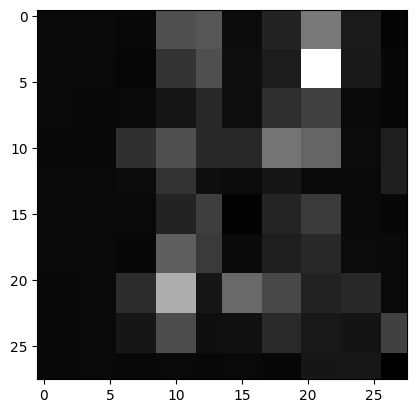

In [73]:
import torch
import matplotlib.pyplot as plt

# Load the trained model
# model = LatentDiffusionModel(num_steps=1000, beta_schedule=beta_schedule, image_size=image_size, num_classes=num_classes)

save_dir = "checkpoints"
checkpoint = torch.load(os.path.join(save_dir, "test_model.pth"))
model.load_state_dict(checkpoint['model'])

model.eval()

# Move the model to the device
# model.to(device)

# Generate a random noise tensor
noise = torch.randn(1, 1, 28, 28).to(device)

# Use the reverse diffusion process to generate a new image
with torch.no_grad():
    generated_image = model.denoise(model.unet(noise, None), None)

# Plot the generated image
plt.imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
plt.show()